# Introduction to pyrolyse

## Table of contents

- [What is pyrolyse?](#What-is-pyrolyse?)
- [Showcase](#Showcase)
   - [Without pyrolyse](#Without-pyrolyse)
   - [With pyrolyse](#With-pyrolyse)
- [Quick How-to](#Quick-How-to)
- [What changes?](#What-changes?)
   - [Some methods become attributes](#Some-methods-become-attributes)
   - [New attributes](#New-attributes)
   - [Optional arguments](#Optional-argument)
   - [Movers are callable](#Movers-are-callable)
   - [Import alternatives](#Import-alternatives)
   - [Docstrings follow numpydoc standards](#Docstrings-follow-numpydoc-standards)
   - [New functions](#New-functions)
- [How to use pyrolyse](#How-to-use-pyrolyse)
- [Features to implement](#Features-to-implement)
   - [Full python logging](#Full-python-logging)
   - [Residue method to get AtomID](#Residue-method-to-get-AtomID)
   - [Digest](#Digest)
- [Pyrolyse limits](#Pyrolyse-limits)
- [Why this name?](#Why-this-name?)
- [Why an independent package?](#Why-an-independent-package?)

(Internal links don't work on GitHub jupyter viewer.)

## What is pyrolyse?

Pyrolyse is a package to run alongside [PyRosetta](https://www.pyrosetta.org), a protein design python package built over [Rosetta](https://www.rosettacommons.org/).

Current PyRosetta automatically converts the whole C++ of Rosetta into a python library, eventually with a few functions and methods added on top. This results in a package not fully using Python syntactic features. Pyrolyse is a module to import after PyRosetta and to use in parallel: it brings minor modifications to PyRosetta python API by dynamically assigning variables and monkey-patching others. Modifications are only syntactic: PyRosetta still works (hopefully) as efficiently as before, but as the [Zen of Python](https://www.python.org/dev/peps/pep-0020/) states: readability counts.

Changes introduced in pyrolyse are similar to the ones introduced in `pyrosetta.bindings`, pushed a step further.

## Showcase

Following is a simple PyRosetta script. It is a possible answer to a problem given in the [notebook 5.02](https://github.com/RosettaCommons/PyRosetta.notebooks/blob/master/student-notebooks/05.02-Refinement-Protocol.ipynb) of [PyRosetta.notebooks](https://github.com/RosettaCommons/PyRosetta.notebooks). The instructions are to create a program doing the following to a molecular structure (a pose):

    1. Five small moves
    2. Minimize
    3. Five shear moves
    4. Minimize
    5. Monte Carlo Metropolis criterion
    6. Repeat 1-5 100 times
    7. Repeat 1-6 five times, each time decreasing the magnitude of the small and shear moves from 25° to 5° in 5° increments.


### Without pyrolyse
**RESTART KERNEL TO RERUN THIS CELL IF PYROLYSE HAS ALREADY BEEN IMPORTED.**

In [1]:
# Please restart kernel if pyrolyse was imported.
import logging

import pyrosetta as pyr
import pyrosetta.rosetta as ros

logger=logging.getLogger('rosetta')
logger.setLevel('INFO')
pyr.init(set_logging_handler=True)
logger.setLevel('WARNING')    # Disables all logs.


def folding(pose):
    """Fold a pose using SmallMover and ShearMover

    Parameters
    ----------
    pose: pyrosetta.rosetta.core.pose.Pose

    Returns
    -------
    folded_pose: pyrosetta.rosetta.core.pose.Pose
    """
    folded_pose = pyr.Pose()
    folded_pose.assign(pose)

    mmap = pyr.MoveMap()
    mmap.set_bb(True)
    sfxn = pyr.get_score_function(is_fullatom=True)

    min_mv = ros.protocols.minimization_packing.MinMover()
    min_mv.movemap(mmap)
    min_mv.score_function(sfxn)

    small_mv = ros.protocols.simple_moves.SmallMover(mmap, 1., 5)
    shear_mv = ros.protocols.simple_moves.ShearMover(mmap, 1., 5)

    # Modify magnitude by 5° increments
    for magnitude in range(25, 4, -5):
        for sec_struct in "HEL":
            small_mv.angle_max(sec_struct, magnitude)
            shear_mv.angle_max(sec_struct, magnitude)

        seq_mv = pyr.SequenceMover()
        for mover in (small_mv, min_mv, shear_mv, min_mv):
            seq_mv.add_mover(mover)

        mc_mv = pyr.MonteCarlo(pose, sfxn, 1.)
        trial_mv = pyr.TrialMover(seq_mv, mc_mv)

        hundred_trials = pyr.RepeatMover(trial_mv, 100)

        hundred_trials.apply(folded_pose)
        print(f'Maximum angle change: {magnitude}°, score: {sfxn(folded_pose)}')

    return(folded_pose)

pose = pyr.pose_from_sequence('AS'*10)
folded_pose = folding(pose)

INFO:rosetta:core.init: Checking for fconfig files in pwd and ./rosetta/flags
INFO:rosetta:core.init: Rosetta version: PyRosetta4.Release.python38.linux r266 2020.39+release.9ee477a 9ee477a1d9d615da653167cf059551268713dda2 http://www.pyrosetta.org 2020-09-24T22:05:54
INFO:rosetta:core.init: command: PyRosetta -ex1 -ex2aro -database /home/circux/.pyenv/versions/miniconda3-latest/envs/struct/lib/python3.8/site-packages/pyrosetta-2020.39+release.9ee477a-py3.8-linux-x86_64.egg/pyrosetta/database
INFO:rosetta:basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1447749450 seed_offset=0 real_seed=1447749450
INFO:rosetta:basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1447749450 RG_type=mt19937


PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python38.linux 2020.39+release.9ee477a1d9d615da653167cf059551268713dda2 2020-09-24T22:05:54] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
Maximum angle change: 25°, score: 156.53431149013014
Maximum angle change: 20°, score: 153.65668580922622
Maximum angle change: 15°, score: 146.67082385005284
Maximum angle change: 10°, score: 147.0112915411109
Maximum angle change: 5°, score: 147.04171535144303


To be noted that PyRosetta is usually imported using wildcard. Quoting [PEP8](https://pep8.org/#imports), "wildcard imports (from <module> import *) should be avoided, as they make it unclear which names are present in the namespace". You can contact me at <olaprevote@protonmail.com> to get my full opinion on this matter applied to PyRosetta.

### With pyrolyse

Comments featuring equivalent lines in pure PyRosetta were put to prevent intensive back-and-forth scrolling.

In [3]:
import pyrosetta as pyr
import pyrosetta.rosetta as ros
import pyrolyse.all as lys

# import logging
# logger = logging.getLogger('rosetta')
# logger.setLevel('INFO')
lys.logger.setLevel('INFO')
lys.init()
lys.logger.setLevel('WARNING')    # Disables all logs.


def folding(pose):
    """Fold a pose using SmallMover and ShearMover

    Parameters
    ----------
    pose: pyrosetta.rosetta.core.pose.Pose

    Returns
    -------
    folded_pose: pyrosetta.rosetta.core.pose.Pose
    """
    folded_pose = pyr.Pose()
    folded_pose.assign(pose)

    # mmap = pyr.MoveMap()
    # mmap.set_bb(True)
    mmap = pyr.MoveMap(bb=True)
    sfxn = pyr.get_score_function(is_fullatom=True)

    # min_mv = ros.protocols.minimization_packing.MinMover()
    # min_mv.movemap(mmap)
    # min_mv.score_function(sfxn)
    min_mv = lys.movers.min_pack.MinMover(movemap=mmap, sfxn=sfxn)

    # small_mv = ros.protocols.simple_moves.SmallMover(mmap, 1., 5)
    small_mv = lys.movers.simple.SmallMover(mmap, 1., 5)
    shear_mv = lys.movers.simple.ShearMover(mmap, 1., 5)

    # Modify magnitude by 5° increments
    for magnitude in range(25, 4, -5):
        # for sec_struct in "HEL":
        #     small_mv.angle_max(sec_struct, magnitude)
        new_angles = {'H': magnitude, 'E': magnitude, 'L': magnitude}
        small_mv.angles_max = new_angles
        shear_mv.angles_max = new_angles

        # for mover in (small_mv, min_mv, shear_mv, min_mv):
        #     seq_mv.add_mover(mover)
        seq_mv = pyr.SequenceMover(movers=[small_mv, min_mv, shear_mv, min_mv])

        mc_mv = pyr.MonteCarlo(pose, sfxn, 1.)
        trial_mv = pyr.TrialMover(seq_mv, mc_mv)

        hundred_trials = pyr.RepeatMover(trial_mv, 100)

        # hundred_trials.apply(folded_pose)
        hundred_trials(folded_pose)
        print(f'Maximum angle change: {magnitude}°, score: {sfxn(folded_pose)}')

    return(folded_pose)

pose = lys.get_pose('AS'*10)
folded_pose = folding(pose)

INFO:rosetta:core.init: Checking for fconfig files in pwd and ./rosetta/flags
INFO:rosetta:core.init: Rosetta version: PyRosetta4.Release.python38.linux r266 2020.39+release.9ee477a 9ee477a1d9d615da653167cf059551268713dda2 http://www.pyrosetta.org 2020-09-24T22:05:54
INFO:rosetta:core.init: command: PyRosetta -ex1 -ex2aro -database /home/circux/.pyenv/versions/miniconda3-latest/envs/struct/lib/python3.8/site-packages/pyrosetta-2020.39+release.9ee477a-py3.8-linux-x86_64.egg/pyrosetta/database
INFO:rosetta:basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=2056112888 seed_offset=0 real_seed=2056112888
INFO:rosetta:basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=2056112888 RG_type=mt19937


PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python38.linux 2020.39+release.9ee477a1d9d615da653167cf059551268713dda2 2020-09-24T22:05:54] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
Maximum angle change: 25°, score: 187.62628226150395
Maximum angle change: 20°, score: 181.8901692547512
Maximum angle change: 15°, score: 169.77263600535073
Maximum angle change: 10°, score: 165.87733285165515
Maximum angle change: 5°, score: 162.6435207119891


The differences introduced are small, but it is hoped that by implementing small changes in syntaxes pyrolyse can make scripting with PyRosetta a smoother experience for the writer as well as for the reader, while not breaking too many habits of seasoned users.

## Quick How-to

Just write `import pyrolyse.all as lys` in the import section, it will change how PyRosetta objects behave. Explanations and more complex uses are described in [How to use pyrolyse](#How-to-use-pyrolyse)

## What changes?

### Some methods become attributes

  Methods which only get or get/set values without any additional argument were simply transformed into attributes, e.g.
```python
pose.pdb_info().name()
pose.pdb_info().name('foo')
```

becomes after pyrolyse import

```python
pose.pdb_info.name
pose.pdb_info.name = 'foo'
```
Methods standing there to have read-only attributes remain read-only. As getting and setting variables is just calling their `__get__` and `__set__` methods, type restrictions remain.

Not every method simply returning a value without any argument were converted to attribute. For example, any verbal method was kept as is, like `pose.residue(1).is_backbone()` or even `pose.residue(1).connected_residue_as_lower()` using past-participal form. This follows what is done in built-in methods like `"12".isdigit()` (except past-participal form: this is open to discussion).
  
To be noted that methods which may take an argument (except for setting) are still methods, so it is `pose.sequence` but `pose.annotated_sequence()`.
  
This improves readability as the intent is clearly stated. Not only that: whether in jupyter notebooks or in an interactive python console, tab completion allows to see which element is a method and which an attribute. This makes different elements purpose clearer.

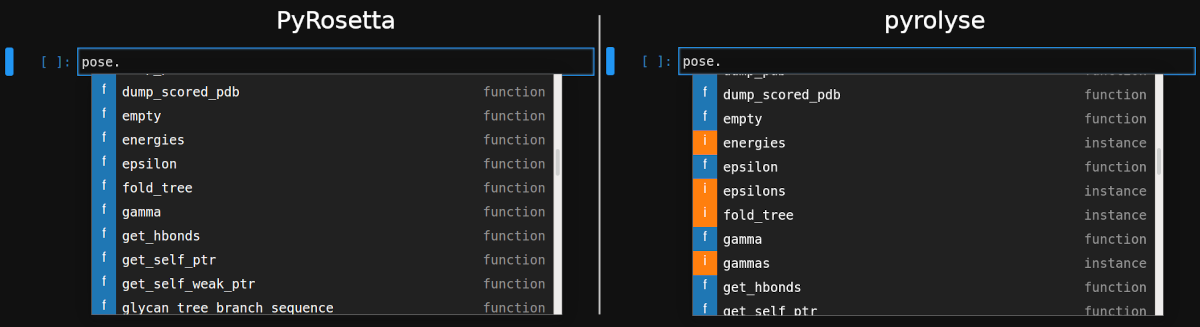

In [4]:
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
from pathlib import Path

InteractiveShell.ast_node_interactivity = "all"
gifPath = Path("./media/tab_completion.png")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png', width='800')

One unusual implementation is the addition of CallableProperty. This was made for `SmallMover.movemap`, which would work as follow in pure PyRosetta:
 
```python
>>> small_mv.movemap(mmap) # Set a new movemap
>>> small_mv.movemap
<bound method Pycapsule.movemap of <pyrosetta.rosetta.protocols.simple_moves.SmallMover object at 0x7fb90d68b6b0>>
>>> small_mv.movemap()
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
TypeError: movemap(): incompatible function arguments. The following argument types are supported:
    1. (self: pyrosetta.rosetta.protocols.simple_moves.BackboneMover, new_movemap: pyrosetta.rosetta.core.kinematics.MoveMap) -> None
    2. (self: pyrosetta.rosetta.protocols.simple_moves.BackboneMover, pose: pyrosetta.rosetta.core.pose.Pose) -> pyrosetta.rosetta.core.kinematics.MoveMap
>>> applied_mmap = small_mv.movemap(pose)   # Called on pose 
```

The method was transformed so that setting the movemap with `=` would also be possible:
```python
small_mv.movemap = mmap
```

Calling movemap with arguments the old way is possible too but trying to get it like an attribute, e.g. `print(small_mv.movemap)` won't work.

### New attributes
 
  Like data descriptors, for example `pose.residues` defined in `pyrosetta.bindings`, a few attributes have been added to fully use python built-in objects. One example can be found in the [showcase](#With-pyrolyse) with `SmallMover.angles_max`, returning a dictionary-like instance but with items bound to mover methods. This allows clearer and faster-to-write approaches:

In [4]:
from pyrolyse.movers.simple import SmallMover

small_mv = SmallMover()

# Pure PyRosetta way to do it
small_mv.angle_max('H', 3)
small_mv.angle_max('E', 20.5)
small_mv.angle_max('L', 30.)

# Ways enabled by pyrolyse
small_mv.angles_max['H'] = 0.
small_mv.angles_max['E'] += 5
# small_mv.angle_max('L'. small_mv.angle_max('L')/3)
small_mv.angles_max['L'] /= 3.
print(small_mv)

# If one ever forgets characters representing secondary structures
print(small_mv.angles_max.keys())

# Redefine everything
small_mv.angles_max = dict(H=10., E=5, L=0.5)

# The setter method loops through the setted dict: an omitted argument will
# simply not be changed.
small_mv.angles_max = {'E': 5., 'L': 0}

# Set everything to 0. Possible but longer and less clear than above.
small_mv.angles_max = {key: 0. for key in small_mv.angles_max}
print(small_mv)

Mover name: Small, Mover type: SmallMover, Mover current tag:NoTag
Max angle for helices (H): 0
Max angle for strands (E): 25.5
Max angle for loops (L):   10
Temperature factor (kT):   0.5
Number of moves:           1

dict_keys(['H', 'E', 'L'])
Mover name: Small, Mover type: SmallMover, Mover current tag:NoTag
Max angle for helices (H): 0
Max angle for strands (E): 0
Max angle for loops (L):   0
Temperature factor (kT):   0.5
Number of moves:           1



  `AngleMaxDict` are nice tools, but `simple_moves` objects are probably not so useful in actual protein design scripts.
  
  In Pose objects, `TorsionList` like `psis` and `phis` were introduced. Their indices are linked to the pose torsion angles. To be noted that they are currently 0-indexed and not 1-indexed like the rest of PyRosetta. This makes some interesting uses easier.

PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python38.linux 2020.39+release.9ee477a1d9d615da653167cf059551268713dda2 2020-09-24T22:05:54] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


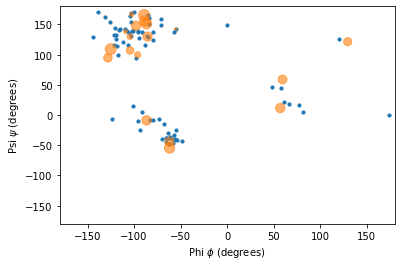

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import pyrolyse.all as lys


lys.init()
pose = lys.get_pose('1UBQ')  # get_pose recognizes RCSB ids

old_psis = pose.psis
old_phis = pose.phis

# Make perturbations
lim = 20
var = np.zeros((2, len(pose.psis)))
var[:,-lim:] = 10*np.random.randn(2, lim)

# Perturbs 20 last residues
pose.psis = np.add(pose.psis, var[0])

# Slices work too
pose.phis[-lim:] = np.add(pose.phis[-lim:], var[1,-lim:])

# Quick Ramachandran map
# Orange dot size is proportional to sum of torsion variation
size = np.sum(np.abs(var), axis=0) * 5
plt.scatter(old_phis, old_psis, s=10.)
plt.scatter(pose.phis, pose.psis, alpha=.6, s=size)

plt.axis([-180., 180., -180., 180.])
plt.xlabel(r'Phi $\phi$ (degrees)')
plt.ylabel(r'Psi $\psi$ (degrees)')

plt.show()

*Ramachandran map. Blue dots are before modification, orange dots are the modified residues, their size is proportional to the variation introduced.*

Another useful planned attribute (**not yet implemented**) could be useful would be for MoveMap.
Movemaps set how residues of a pose are allowed to move when a mover modifies it. Currently, if it is wanted to allow a residue to have its backbone torsion angles changed, or a range of residues, one should write:

```python
movemap.set_bb(False)
movemap.set_bb(1, True)
movemap.set_bb_true_range(5,10)
print(movemap.get_bb(5))
```

If this was a (1-indexed) iterable attribute instead, the same could be written:

```python
movemap.bb = False
movemap.bb[1] = True
movemap.bb[5:10] = True
print(movemap.bb[5])
```

Almost the same, but this time remembering how three different methods work is not needed. This would also allow a few funnier things:

```python
movemap.bb[-1] = True   # Last residue backbone can move
movemap.bb[::3] = True  # Backbone of one residue every 3 residue can move
                        # Not sure this can be done

# Easy to custom
movemap.bb[5:11] = [False, True, False, True, True, False]

# Whether backbone can move or not is random for each residue
movemap.bb = np.random.rand(len(movemap.bb)) > .5

print(movemap.bb[-5])   # List of bool, the bb value of the last 5 residues
print(movemap.bb)       # List of bool. 
                        # All True or False can be checked with any() and all()
```

Again, **this feature is not yet implemented and is currently wishful thinking.**

### Optional arguments

This was a great introduction to another feature: keyword arguments.

Keyword arguments do exist in C++, yet it is either lost in translation into python or there just aren't many in Rosetta to begin with. In pure PyRosetta, making a movemap with backbone, jumps and chis allowed to move would be:

```python
mmap = pyr.movemap()
mmap.set_bb(True)
mmap.set_jump(True)
mmap.set_chi(True)
```
Now it can be:
```python
mmap = pyr.movemap(bb=True, jump=True, chi=True)
```

These new arguments were also introduced in movers, for example `MinMover`. Still in the showcase, in pure PyRosetta version:

```python
min_mv = ros.protocols.minimization_packing.MinMover()
min_mv.movemap(mmap)
min_mv.score_function(sfxn)
```

You can already see where this is going. However this is cheating, this time someone could actually write in pure PyRosetta:

```python
min_mv = ros.protocols.minimization_packing.MinMover(movemap_in=mmap,
                                                     score_fxn_in=sfxn)
```

Keywords aren't even needed. But in pure PyRosetta, it isn't possible to specify one argument only and give the other one later. Why would anyone want to do that? No idea, but at least it's possible with pyrolyse:

```python
min_mv = lys.movers.min_pack.MinMover(sfxn=sfxn)
min_mv.movemap = mmap
print(min_mv.movemap, min_mv.sfxn)
```

`sfxn` instead of `score_function` is healthy laziness. The abbreviation is already spread everywhere in [PyRosetta.notebooks](https://github.com/RosettaCommons/PyRosetta.notebooks).

Finally, one little yet practical change is the SequenceMover taking movers as a list:

```python
seq_mv = pyr.SequenceMover(movers=[small_mv]*4 + [shear_mv]*2)
```

In pure PyRosetta, this would either give:

```python
seq_mv = pyr.SequenceMover()
repeat_small = pyr.RepeatMover(small_mv, 4)
repeat_shear = pyr.RepeatMover(shear_mv, 2)
seq_mv.add_mover(repeat_small)
seq_mv.add_mover(repeat_shear)
```

Or, python-flavored (wich is what happens under the hood here):
```python
seq_mv = pyr.SequenceMover()
for mover in [small_mv]*4 + [shear_mv]*2:
    seq_mv.add_mover(mover)
```

This also makes it quite easier to apply a large sequence of movers to a pose:
```python
long_sequence_of_movers = [first_mv, second_mv, ..., nth_mv]
seq_mv = pyr.SequenceMover(movers=long_sequence_of_movers)
seq_mv(pose)
```
Althoug once again, a one-liner would also be possible (would work in pure PyRosetta and with pyrolyse):
```python
map(lambda mover: getattr(mover, apply)(pose), long_sequence_of_movers)
```

### Movers are callable

It may have been noticed two examples above. Only movers modified by pyrolyse, though. Calling them is equivalent to calling `apply` method.

### Import alternatives

`import pyrolyse.all` transforms PyRosetta objects, hence `pyrolyse` module organization doesn't need to mirror PyRosetta one. PyRosetta organizes things by general theme, like `pyrosetta.rosetta.protocols.simple_moves` containing every objects worthy of being in the theme `simple_moves`, be it Movers, MoverCreators or ThermodynamicData. It makes sense given that many modules are developed by independent laboratories. Instead, pyrolyse organizes this by objects first, so `pyrolyse.movers.simple` contains every movers from `simple_moves` and only the movers, and `pyrolyse.movers` contains every movers edited by pyrolyse. Also, pyrolyse goal is to make PyRosetta use easier when doing protein design, so it can be a bit flattened as it intends to "only" deal with `core` and `protocols` modules and not `utility`, `basics`, `apps`, `platform` or `numeric`, or so it is hoped.

This way users are provided with an alternative: if someone believes the PyRosetta imports are always clearer, then they can keep using them while using the other functionalities of pyrolyse, but if it is believed that this particular time it will be shorter and more understandable to import from pyrolyse then please go on. Hopefully the [showcase](#With-pyrolyse) shows how useful it can be to be able to combine both.

### Docstrings follow numpydoc standards

[Numpydoc standards](https://numpydoc.readthedocs.io/en/latest/format.html) are already used by several structural biology python packages, including [ParmEd](https://github.com/ParmEd/ParmEd), [MDAnalysis](https://github.com/MDAnalysis/mdanalysis), [OpenMM](https://github.com/openmm/openmm), [MDTraj](https://github.com/mdtraj/mdtraj) and [pyEMMA](https://github.com/markovmodel/PyEMMA).

Because class are dynamically changed, the easiest way to know if you are dealing with a PyRosetta or pyrolyse object is either to call an attribute and see if it throws an error or not, or alternatively to use `help` or `?` on the object and see if the doc is different.

Here is how it looks in numpydoc style:

In [98]:
lys.MoveMap?

Init signature:
lys.MoveMap(
    *args,
    bb=False,
    branches=False,
    chi=False,
    jump=False,
    nu=False,
    **kwargs,
)
Docstring:     
Class specifying DOFs to be flexible or fixed

Currently there are two groups of data, one is a residue-based Torsion
definition, such as BB, CHI, NU, and JUMP; the other is an atom-based DOF
definition, such as bond length D, bond angle THETA, and torsion angle PHI,
which are used in the AtomTree. MoveMap does not automatically handle
conversion from one group to the other, i.e., setting PHI false for
DOF_type does not affect setting for BB and CHI torsion though they are
PHIs in atom-tree.

Within each group, there are multiple levels of control
(from general/high to specific/lower):


Torsion-based: TorsionType(BB, CHI, NU, BRANCH, JUMP) -> MoveMapTorsionID
(BB, CHI of one residue) -> TorsionID ( BB torsion 2 or CHI torsion 3 of
one residue)


DOF-base: DOF_type( D, THETA, PHI ) -> DOF_ID (D, THETA, PHI of one atom)

Settings for each

Keyword arguments introduced by pyrolyse figure in Other Parameters, while original possible arguments are stated in Parameters. New examples are also added to reflect the changes.

Note that creating a new movemap over an existing one has never been this fancy. Also note that although this is how it should be, currently not all object modified by pyrolyse have this.

For comparison sake, here is what `pyr.MoveMap?` looks like without pyrolyse:

```
Docstring:     
A class specifying DOFs to be flexible or fixed


Currently there are two groups of data, one is a residue-based Torsion
definition, such as BB, CHI, NU, and JUMP; the other is an atom-based DOF
definition, such as bond length D, bond angle THETA, and torsion angle PHI,
which are used in the AtomTree. MoveMap does not automatically handle
conversion from one group to the other, i.e., setting PHI false for
DOF_type does not affect setting for BB and CHI torsion though they are
PHIs in atom-tree.

Within each group, there are multiple levels of control
(from general/high to specific/lower):


Torsion-based: TorsionType(BB, CHI, NU, BRANCH, JUMP) -> MoveMapTorsionID
(BB, CHI of one residue) -> TorsionID ( BB torsion 2 or CHI torsion 3 of
one residue)


DOF-base: DOF_type( D, THETA, PHI ) -> DOF_ID (D, THETA, PHI of one atom)

Settings for each level are stored in a map structure and they are only
added to the map when setting methods are invoked. As a result, MoveMap
does not behave like a "Boolean vector", which always contains setting for
each residue or atom in a conformation. Setting for a higher level will
override setting for lower levels (remove it from map); Similarly, when
querying a lower level finds no setting, it will check setting for its
higher level. For example, setting TorsionType BB to be true will remove
any data of BB setting for a residue or a specific BB torsion (such as
backbone psi) in a residue. And querying the setting for BB torsion 2 of
residue 4 will first check if there is any specific setting, if not, it will
check if there is a setting for all BB torsions for residue 4, if not
again, it will use the setting for BB torsions for all residues.

Example:
    movemap = MoveMap()
See also:
    Pose
    MinMover
    ShearMover
    SmallMover
Init docstring:
__init__(*args, **kwargs)
Overloaded function.

1. __init__(self: pyrosetta.rosetta.core.kinematics.MoveMap) -> None

2. __init__(self: pyrosetta.rosetta.core.kinematics.MoveMap, arg0: pyrosetta.rosetta.core.kinematics.MoveMap) -> None
Type:           pybind11_type
Subclasses:     
```

This is almost the end of the tour: there is only one thing remaining.

### New functions

There are currently only two: `init` and `get_pose`.
`get_pose` is probably the most straightforward, it automatically parses your input for the pose and uses the right function to get it.

In [6]:
import pyrosetta as pyr
import pyrolyse as lys

lys.init(extra_options='-out:level 200')
lys.logger.setLevel('INFO')

# Pure PyRosetta way:
pose_rcsb = pyr.toolbox.rcsb.pose_from_rcsb('1UBQ')
pose_file = pyr.pose_from_file('inputs/1afo.pdb')
try:   # pyrosetta pose_from_sequence doesn't work with pyrolyse pose
    pose_sequence = pyr.pose_from_sequence('AAAA')
except TypeError:
    print('PyRosetta Pose is modified, hence pose_from_sequence crashed.')

lys.logger.setLevel('WARNING')

pose_rcsb = lys.get_pose('1UBQ')
pose_sequence = lys.get_pose('AAAA')
pose_file = lys.get_pose('inputs/1afo.pdb')

PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python38.linux 2020.39+release.9ee477a1d9d615da653167cf059551268713dda2 2020-09-24T22:05:54] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


INFO:rosetta:core.import_pose.import_pose: File '1UBQ.clean.pdb' automatically determined to be of type PDB
INFO:rosetta:core.import_pose.import_pose: File 'inputs/1afo.pdb' automatically determined to be of type PDB
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 1 in file inputs/1afo.pdb. Best match rsd_type:  VAL:NtermProteinFull
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 41 in file inputs/1afo.pdb. Best match rsd_type:  VAL:NtermProteinFull
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 81 in file inputs/1afo.pdb. Best match rsd_type:  VAL:NtermProteinFull
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 121 in file inputs/1afo.pdb. Best match rsd_type:  VAL:NtermProteinFull
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 161 in fi

PyRosetta Pose is modified, hence pose_from_sequence crashed.


You can create a new cell and look at `get_pose` documentation to see how it chooses. It is also possible to enforce which type of pose to expect, for example `pose_crash = lys.get_pose('inputs/1afo.pdb', 'sequence')` will try to use `pose_from_sequence`. (More about why PyRosetta `pose_from_sequence` is not usable in the [Pyrolyse limits](#Pyrolyse-limits) section.)

`pyrolyse.init` simply sets `set_logging_handler` to True by default instead of False. It takes the same arguments as `pyrosetta.init` and calls it. There is also a global object `pyrolyse.logger` wich is simply a more simple way to access the python logger. It is a feature already implemented in `PyRosetta`, and sometimes silencing `Rosetta` depending on the context is nice, especially when using an interactive flavor of python. Hopefully the output above helps to make it understood why being easily able to put logging on and off depending on context may be interesting.

## How to use pyrolyse

As said before, pyrolyse performs monkey-patching of multiple PyRosetta classes, meaning it dynamically replaces class attributes. One simple example of monkey-patch would be **(don't run this cell if you don't want to have to restart your kernel)**:

In [1]:
from pyrosetta import Pose
from pyrolyse import init, get_pose


init()

original_pose = get_pose('Y')
atm_id = original_pose.residue(1)
print('\noriginal_pose.residue(1).atom(1)', original_pose.residue(1).atom(1))

# Monkey-patching Pose class
Pose.residue = 1
monkey_pose = Pose()

print('Now every Pose have a unusable residue method:',
      '\n - original pose.residue:', original_pose.residue,
      '\n - monkey_pose.residue:', monkey_pose.residue,
      '\n - monkey_pose has a pyrosetta Pose class:', monkey_pose.__class__,)

try:
    print('Calling pose.residue:', monkey_pose.residue(1))
except TypeError:
    print('pose.residue is no longer callable.')

PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python38.linux 2020.39+release.9ee477a1d9d615da653167cf059551268713dda2 2020-09-24T22:05:54] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.

original_pose.residue(1).atom(1) 0, 0, 0
Now every Pose have a unusable residue method: 
 - original pose.residue: 1 
 - monkey_pose.residue: 1 
 - monkey_pose has a pyrosetta Pose class: <class 'pyrosetta.rosetta.core.pose.Pose'>
pose.residue is no longer callable.


If you ran this cell you now have a Pose where you can't access residue objects using the python API, and you may want to restart the kernel of this notebook (shortcut: press two times zero).
Objects defined in C++ and imported in python still can access this, though, so applying a Rosetta mover on it should probably work.

As stated in `pyrosetta.bindings.utility.bind_method` docstring: "C++ objects are not explicitly defined in the python code. Therefore, dynamically defining is the only option." This means that if one wants to change PyRosetta behavior, class inheritance won't work. It is only possible to define new variables or to redefine existing ones.

The class of an object remains the same, whether using the original or the edited one. This has one minor drawback: it's hard to directly see which version is being used, but except if you have had your python interactive console opened for a very long time or ran too many jupyter notebook cells it shouldn't be a problem. Worst case scenario you get an error. This also has one major advantage: any function or method returning this object will return its modified version. This is why it's still possible to write:

```python
mmap = pyr.MoveMap(bb=True)
pose = pyr.pose_from_file('path/to/file.pdb')
```

And get a movemap and a pose with behavior modified by pyrolyse.

As shown previouly, `pyrolyse` doesn't use monkey-patching to transform a pretty method into an integer. Instead it uses it to convert class methods into attributes using said class methods as getters and setters of a `property` object, among other things.

Creating a read-only attribute or a settable attribute takes only one line using `property` class, already used in `pyrosetta.bindings` module. As of how it exactly works you can take a peak in the source code, not as clean and commented as it should be but hopefully understandable.

The transformation in action would look like the following. If it isn't already done: **restart your kernel (0,0 a.k.a double tap on zero)** to erase all of pyrolyse modifications on PyRosetta.

In [1]:
from pyrosetta.rosetta.core.pose import Pose, PDBInfo
import pyrolyse

pyrolyse.init()

pose = Pose()
pdb_info = PDBInfo()
pdb_info.name('OriginalPose')

try:
    pose.pdb_info(pdb_info)
    print("\npose.pdb_info().name():", pose.pdb_info().name())
except TypeError:
    print(('\nError caught. pose.size has already been modified by pyrolyse'
           'and is not callable anymore. Restart your kernel?'))


import pyrolyse.core.pose
print('\npyrolyse imported')

new_pdb_info = PDBInfo()
new_pdb_info.name('EditedPose')
pose.pdb_info = new_pdb_info

print('pose.pdb_info.name():', pose.pdb_info.name())

PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python38.linux 2020.39+release.9ee477a1d9d615da653167cf059551268713dda2 2020-09-24T22:05:54] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.

pose.pdb_info().name(): OriginalPose

pyrolyse imported
pose.pdb_info.name(): EditedPose


Attentive readers may notice two things:
1. pyrolyse was imported to use its init function, yet PyRosetta `Pose` worked as always.
2. `PDBInfo.name` was still a method, not an attribute after `import pyrolyse.core.pose`.

This is because pyrolyse never monkey-patches classes except if they are imported from pyrolyse at some point. `import pyrolyse` only imports utilities like `get_pose` wich don't edit any PyRosetta object behavior. This way, if someone wants to only work with PyRosetta `Pose` normal behavior but `MoveMap` and `Movers` with pyrolyze behavior, it would be possible.
`import pyrolyse.all` sets up every pyrolyse behavior. It can always be written `import pyrolyse.all as lys` to use pyrolyse module organization, just like in the [showcase](#With-pyrolyse).

`core` and `movers` are different, too. In substance, `import pyrolyse.core` wouldn't import anything, while `import pyrolyse.movers` would edit every movers defined there.
This means that
```python
from pyrolyse.movers.simple import SmallMover
```
will import SmallMover but will also change every other movers behavior. See this as a guarantee of consistancy in a script.

This may change, as probably no one wants a pyrolysed `Pose` with pure PyRosetta `PDBInfo` or `Residue` and to avoid having scripts using one way and other scripts another, confusing the reader.

## Features to implement

Changes to MoveMap were explained earlier.

### Full python logging

Currently every logs of Rosetta, regardless of their level, are outputed at `INFO` log level when using the python logging handler, hence it is either everything or nothing. It would be interesting to convert warnings to warnings, infos to infos and debugs to debugs and to be able to switch between them. One dirty possible way to do it would be to set `pyrosetta.logging_support.PythonLoggingSink` to set the log  level of `logstring` depending on present keywords, like `WARNING`, but it should first be explored if there is not a more elegant way.

Another idea would be to have a module variable `pyrolyse.LOG` which stores any logs outputs at `INFO` level or more. The variable would be limited to a maximal size and could be checked if one had a problem while not outputing logs. This could be especially handy in case of long processes.

### Residue method to get AtomID

In PyRosetta, some methods may ask for an `AtomID`, for example `pose.set_xyz()`.
It would seem only natural to try getting an AtomID with `pose.residue(1).atoms(1)` or `pose.residue(1).atom_index("N")` or similar. This would return an `Atom` object, though. To get an `AtomID` , the `Atom` object has to be written:

```python
atm_id = pyr.AtomID(pose.residue(1).atom_index('N'), pose.residue(1))
```

Instead it would be interesting to write a method `pose.residue(1).atom_id(1)` and `pose.residue(1).atom_id('N')` returning an `AtomID`.

### Digest

Currently the easiest way to check a mover or a movemap global parameters is by printing them. Most of the time, these objects `__repr__` methods are organized like a dictionary, or in the case of datadescriptors could be seen as a `pandas.DataFrame`. The goal would be to have a `pyrolyse.digest()` function wich could take any kind of PyRosetta object and, based on their `__rep__` and other magic methods, outputs a dict. Could always be interesting to access not everything but a part of global informations.

## Pyrolyse limits

- It is impossible to revert back to PyRosetta pure behavior after pyrolyse import. It is a false problem, though: except in particular cases like testing or comparing before and after import it shouldn't be a major issue. It only makes it mandatory to keep the same behavior through an entire script, which sounds like a sane practice.

- pose_from_sequence and other functions defined in python, or methods from data-descriptors, break as methods are transformed in non-callable attributes. What has been done now was to rewrite these methods and function, but in the case of functions they can't be monkey-patched, so they are only redefined. A `pose_from_sequence` working with any kind of Pose can be found in `pyrolyse.utils`.

- parmed or other packages integration are broken upon pyrolyse import. It is only a matter of taking their source-code and suppressing a few parenthesis in front of attributes, so it can be easily fixed, yet functions still have to be rewritten. PyMOL integration hasn't been tested yet: as it is normally managed by the C++ Rosetta side it is possible that it still works.

## Why this name?

It stands for PyRosetta lysis, given it tries to digest PyRosetta. Also, as of October 2020 it was not a name taken on PyPI. Finally, its diminunitive `lys` stands for lilies in French. Hence:

```python
import pyrosetta.rosetta as ros
import pyrolyse.all as lys
```

is the promise of a flowery code. (`rose` as a diminutive of `pyrosetta.rosetta` was rejected, because of healthy laziness upon writing one more character but also due to its similarity to `pose`.)

## Why an independent package?

There are many incentives for not writing pyrolyse as a PyRosetta module, or commiting it as direct changes to PyRosetta API:

1. To keep PyRosetta backward compatibility

2. To be free of Washington University Academic License<br>
   And hopefully make it possible to publish it on PyPI, so that installing it is as easy as `pip install pyrolyse`, and public on GitHub so anyone can easily contribute.

3. Because PyRosetta is big<br>
   Current pyrolyse probably covers less than a percent of what lies in PyRosetta. Given that "transforming methods to attributes" and such rely on rules like "not if it is a verb", the process can probably be half authomatized at best and still needs human work behind. So it takes time, and before it is fully done (if it ever does as Rosetta is an ever growing software) it is probably better to let people choose whether they want to use it or not, and to explicitly specify when they do.

4. Because PyRosetta doesn't need to get bigger<br>
   At least not for matters as trivial as optional syntax. If someone doesn't dim pyrolyse worth the shot and won't use it, then better leave the choice of whether it should be installed or not.
   
5. Because as it is a young independant initiative developed by a single person its relevance is hard to judge<br>
   So it better stay as independant as possible for now, this way if no one cares I can still make it grow depending on my uses, and if a few people find it interesting we can make it grow depending on ours.